<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [169]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [170]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-01-17 04:38:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.1s    

2021-01-17 04:38:32 (227 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [171]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [172]:
df.shape

(346, 10)

### Convert to date time object 

In [173]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [174]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [175]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

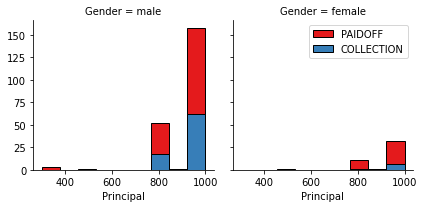

In [176]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

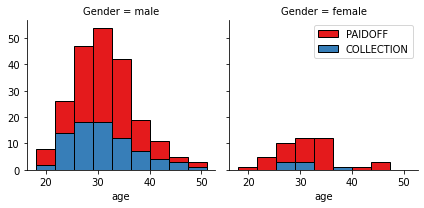

In [177]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

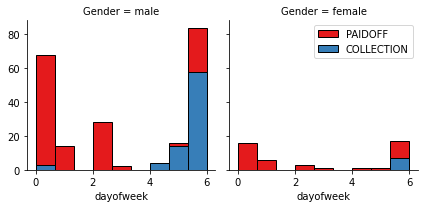

In [178]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [179]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [180]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [181]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [182]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [183]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [184]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [185]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [186]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [187]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [224]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [225]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Finding best K for classification
K=10
acc_list = list()

for k in range(1,K):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    
    # Predicting
    yhat1 = neigh.predict(X_test)
    
    # Evaluation
    acc_list.append([k, metrics.accuracy_score(y_test, yhat1)])

# Selecting best score    
from operator import itemgetter
maxKval = max(acc_list, key=itemgetter(1))
maxK = maxKval[0]
print("Best k=", maxKval[0], ", score=", maxKval[1])

Best k= 7 , score= 0.7857142857142857


In [226]:
# Classification
k = maxK
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

# Predicting
yhat1 = neigh.predict(X_test)
pd.DataFrame(yhat1).groupby([0])[0].value_counts()

COLLECTION  COLLECTION    12
PAIDOFF     PAIDOFF       58
Name: 0, dtype: int64

In [227]:
# f1_score
from sklearn.metrics import f1_score
f1_score(y_test, yhat1, average='weighted') 

0.7766540244416351

In [228]:
# Encoding prediction & test labels
y_test1 = pd.DataFrame(y_test)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).copy()
yhat1_adj = pd.DataFrame(yhat1)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [229]:
# jaccard_score
from sklearn.metrics import jaccard_score
jaccard_score(y_test1, yhat1_adj)

0.2857142857142857

# Decision Tree

In [230]:
# Import classifier
from sklearn.tree import DecisionTreeClassifier

# Train model & fit
dt = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
dt.fit(X_train,y_train)

# Prediction
yhat2 = dt.predict(X_test)

# Evaluation
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat2) )
pd.DataFrame(yhat2).groupby([0])[0].value_counts()

DecisionTrees's Accuracy:  0.6142857142857143


COLLECTION  COLLECTION    26
PAIDOFF     PAIDOFF       44
Name: 0, dtype: int64

In [231]:
# f1_score
from sklearn.metrics import f1_score
f1_score(y_test, yhat2, average='weighted') 

0.6445993031358885

In [232]:
# Encoding prediction & test labels
y_test2 = pd.DataFrame(y_test)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).copy()
yhat2_adj = pd.DataFrame(yhat2)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [233]:
# jaccard_score
from sklearn.metrics import jaccard_score
jaccard_score(y_test2, yhat2_adj)

0.20588235294117646

# Support Vector Machine

In [234]:
# Import classifier
from sklearn import svm

# Select model & fit
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

# Prediction
yhat3 = clf.predict(X_test)

# Evaluation
# f1_score
from sklearn.metrics import f1_score
f1_score(y_test, yhat3, average='weighted') 

0.7275882012724117

In [235]:
# Encoding prediction & test labels
y_test3 = pd.DataFrame(y_test)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).copy()
yhat3_adj = pd.DataFrame(yhat3)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [236]:
# jaccard_score
from sklearn.metrics import jaccard_score
jaccard_score(y_test3, yhat3_adj)

0.18181818181818182

# Logistic Regression

In [237]:
# Import classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [238]:
# Prediction
yhat4_prob = LR.predict_proba(X_test)
yhat4 = LR.predict(X_test)

In [239]:
# Evaluation

# Log_Loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat4_prob)

0.5772287609479654

In [240]:
# Encoding prediction & test labels
y_test4 = pd.DataFrame(y_test)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).copy()
yhat4_adj = pd.DataFrame(yhat4)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

In [241]:
pd.DataFrame(y_test4).groupby([0])[0].value_counts()

0  0    55
1  1    15
Name: 0, dtype: int64

In [242]:
pd.DataFrame(yhat4).groupby([0])[0].value_counts()

COLLECTION  COLLECTION    11
PAIDOFF     PAIDOFF       59
Name: 0, dtype: int64

In [243]:
# jaccard_score
from sklearn.metrics import jaccard_score
jaccard_score(y_test4, yhat4_adj)

0.08333333333333333

In [244]:
# f1_score
from sklearn.metrics import f1_score
f1_score(y_test4, yhat4_adj, average='weighted') 

0.6670522459996144

In [245]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[46  9]
 [13  2]]


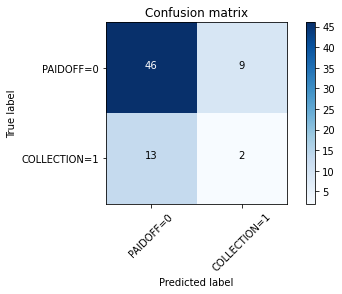

In [246]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test4, yhat4_adj, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test4, yhat4_adj))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=0','COLLECTION=1'],normalize= False,  title='Confusion matrix')

# Model Evaluation using Test set

In [328]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [329]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-17 05:34:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-17 05:34:45 (74.7 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [410]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [411]:
# Convert to datetime object and create weekend
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Encode variable
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Create features and normalize and create target variable
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_testset = Feature
X_testset = preprocessing.StandardScaler().fit(X_testset).transform(X_testset)
y_testset = test_df['loan_status'].values.copy()
y_testset_adj = pd.DataFrame(y_testset)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).copy()
Feature.head()
df_final = pd.DataFrame(index=['Jaccard','F1-score','LogLoss'])

In [412]:
# KNN

# Predicting
yhat_KNN = neigh.predict(X_testset)
yhat_KNN_adj = pd.DataFrame(yhat_KNN)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

# Evaluation
# print("KNN's Accuracy Score: ", metrics.accuracy_score(y_testset, yhat_KNN) )
jaccard = jaccard_score(y_testset_adj, yhat_KNN_adj)
f1 = f1_score(y_testset, yhat_KNN, average='weighted') 
df_KNN = pd.DataFrame([jaccard,f1],index=['Jaccard','F1-score'],columns=['KNN'])
df_final = pd.concat([df_final, df_KNN], axis=1)
print("KNN's Jaccard Score: ", jaccard_KNN )
print("KNN's F1 Score: ", f1_KNN )

pd.DataFrame(yhat_KNN).groupby([0])[0].value_counts()

KNN's Jaccard Score:  0.1
KNN's F1 Score:  0.6328400281888654


COLLECTION  COLLECTION     8
PAIDOFF     PAIDOFF       46
Name: 0, dtype: int64

In [413]:
# Decision Tree

# Prediction
yhat_DT = dt.predict(X_testset)
yhat_DT_adj = pd.DataFrame(yhat_DT)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

# Evaluation
#print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, yhat_DT) )
jaccard = jaccard_score(y_testset_adj, yhat_DT_adj)
f1 = f1_score(y_testset, yhat_DT, average='weighted') 
df_DT = pd.DataFrame([jaccard,f1],index=['Jaccard','F1-score'],columns=['Decision Tree'])
df_final = pd.concat([df_final, df_DT], axis=1)
df_final.append(df_DT)

print("Decision Tree's Jaccard Score: ", jaccard_DT )
print("Decision Tree's F1 Score: ", f1_DT )
pd.DataFrame(yhat_DT).groupby([0])[0].value_counts()

Decision Tree's Jaccard Score:  0.4
Decision Tree's F1 Score:  0.7366818873668188


COLLECTION  COLLECTION    21
PAIDOFF     PAIDOFF       33
Name: 0, dtype: int64

In [414]:
# SVM

# Prediction
yhat_SVM = clf.predict(X_testset)
yhat_SVM_adj = pd.DataFrame(yhat_SVM)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

# Evaluation
jaccard = jaccard_score(y_testset_adj, yhat_SVM_adj)
f1 = f1_score(y_testset, yhat_SVM, average='weighted') 
df_SVM = pd.DataFrame([jaccard,f1],index=['Jaccard','F1-score'],columns=['SVM'])
df_final = pd.concat([df_final, df_SVM], axis=1)

print("SVM's Jaccard Score: ", jaccard_SVM )
print("SVM's F1 Score: ", f1_SVM )
pd.DataFrame(yhat_SVM).groupby([0])[0].value_counts()

SVM's Jaccard Score:  0.26666666666666666
SVM's F1 Score:  0.7583503077293734


COLLECTION  COLLECTION     5
PAIDOFF     PAIDOFF       49
Name: 0, dtype: int64

In [415]:
# Logistic Regression
yhat_Log_prob = LR.predict_proba(X_testset)
yhat_Log = LR.predict(X_testset)
yhat_Log_adj = pd.DataFrame(yhat_Log)[0].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

# Evaluation
jaccard = jaccard_score(y_testset_adj, yhat_Log_adj)
f1 = f1_score(y_testset, yhat_Log, average='weighted')
logloss = log_loss(y_testset, yhat_Log_prob)
df_log = pd.DataFrame([jaccard,f1,logloss],index=['Jaccard','F1-score','LogLoss'],columns=['LogisticRegression'])
df_final = pd.concat([df_final, df_log], axis=1)

print("Logistic Regression's Jaccard Score: ", jaccard_log )
print("Logistic Regression's F1 Score: ", f1_log )
print("Logistic Regression's LogLoss Score: ", logloss_log )
pd.DataFrame(yhat_Log).groupby([0])[0].value_counts()

Logistic Regression's Jaccard Score:  0.06666666666666667
Logistic Regression's F1 Score:  0.6604267310789049
Logistic Regression's LogLoss Score:  0.5672153379912981


COLLECTION  COLLECTION     2
PAIDOFF     PAIDOFF       52
Name: 0, dtype: int64

In [416]:
# Final summary report
df_final

,KNN,Decision Tree,SVM,LogisticRegression
Jaccard,0.10000,0.400000,0.266667,0.066667
F1-score,0.63284,0.736682,0.758350,0.660427
LogLoss,NaN,NaN,NaN,0.567215


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>